In [1]:
# collision_jax_optimized.py
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from jax import jit, lax, vmap

# Enable double precision in JAX (MATLAB uses double precision by default)
jax.config.update("jax_enable_x64", True)

# ---------------------------
# Physical constants & settings
# ---------------------------
ncoll = 100_000

# Molecule database
molecule_params = {
    "H2": {"m_atom": 1.6738e-27, "bondLength": 0.741e-10, "sigma": 3.06e-10, "eps_K": 34.00},
    "N2": {"m_atom": 2.3250e-26, "bondLength": 1.10e-10, "sigma": 3.69e-10, "eps_K": 95.93},
    "O2": {"m_atom": 2.6567e-26, "bondLength": 1.21e-10, "sigma": 3.46e-10, "eps_K": 118.0}
}

molecule = "H2"

m_H  = molecule_params[molecule]["m_atom"]           # hydrogen atom mass [kg]
m_H2 = 2.0*m_H
sigma_LJ = molecule_params[molecule]["sigma"]        # hydrogen-hydrogen LJ sigma [m]
kB = 1.38064852e-23
d_H2 = molecule_params[molecule]["bondLength"]             # hydrogen-hydrogen bond length [m]
I = 0.5 * (d_H2**2) * m_H
epsilon = molecule_params[molecule]["eps_K"]  * kB         # hydrogen-hydrogen LJ well depth [J]

dt = 0.1e-15
tsim = 2e-12
nSteps = int(tsim/dt)

seed = 42
key = jax.random.PRNGKey(seed)

# ---------------------------
# Helper functions
# ---------------------------

@jit
def skew(w):
    wx, wy, wz = w
    return jnp.array([[0.0, -wz, wy],
                      [wz,  0.0, -wx],
                      [-wy, wx, 0.0]])

@jit
def getRandRotMat(key1, key2):
    psi = jax.random.uniform(key1, (), minval=0.0, maxval=2*jnp.pi)
    phi = jnp.arccos(1 - 2*jax.random.uniform(key2, ()))
    theta = 0.0

    Rz = jnp.array([[jnp.cos(psi), -jnp.sin(psi), 0],
                    [jnp.sin(psi),  jnp.cos(psi), 0],
                    [0,             0,            1]])
    Ry = jnp.array([[jnp.cos(theta), 0, jnp.sin(theta)],
                    [0, 1, 0],
                    [-jnp.sin(theta), 0, jnp.cos(theta)]])
    Rx = jnp.array([[1, 0, 0],
                    [0, jnp.cos(phi), -jnp.sin(phi)],
                    [0, jnp.sin(phi),  jnp.cos(phi)]])
    return Rz @ Ry @ Rx

@jit
def LJ_e(r, sigma=sigma_LJ, eps=epsilon):
    sr6 = (sigma / r)**6
    return 4.0 * eps * (sr6*sr6 - sr6)

@jit
def LJ_force_scalar(r, sigma=sigma_LJ, eps=epsilon):
    s6 = sigma**6
    r7 = r**7
    r13 = r**13
    return 24.0*eps*(2.0*(s6**2)/r13 - s6/r7)

@jit
def getFij(Xi, Xj):
    rij = Xi - Xj
    r = jnp.linalg.norm(rij)
    fmag = LJ_force_scalar(r)
    return jnp.where(r>0, (fmag / r) * rij, jnp.zeros(3))

@jit
def getM(F13tr, F14tr, F23tr, F24tr, R1, R2, dH2):
    F13_r = F13tr @ R1
    F14_r = F14tr @ R1
    F23_r = F23tr @ R1
    F24_r = F24tr @ R1
    
    F31_r = -F13tr @ R2
    F41_r = -F14tr @ R2
    F32_r = -F23tr @ R2
    F42_r = -F24tr @ R2

    M1_x = -dH2/2 * (F13_r[1] + F14_r[1]) + dH2/2 * (F23_r[1] + F24_r[1])
    M1_y = dH2/2 * (F13_r[0] + F14_r[0]) - dH2/2 * (F23_r[0] + F24_r[0])
    M1_z = 0.0
    
    M2_x = -dH2/2 * (F31_r[1] + F32_r[1]) + dH2/2 * (F41_r[1] + F42_r[1])
    M2_y = dH2/2 * (F31_r[0] + F32_r[0]) - dH2/2 * (F41_r[0] + F42_r[0])
    M2_z = 0.0
    
    return jnp.array([M1_x, M1_y, M1_z]), jnp.array([M2_x, M2_y, M2_z])

@jit
def getVdot(F, m):
    return F / m

@jit
def getRdot(w, R):
    return R @ skew(w)

@jit
def getWdot(M_body, I_scalar):
    return M_body / I_scalar

@jit
def signed_sqrt(val, key):
    sign = jnp.where(jax.random.uniform(key) > 0.5, 1.0, -1.0)
    return sign * jnp.sqrt(2.0*val/I)

# ---------------------------
# Core simulation
# ---------------------------

@jit
def simulate_one_collision(keys):
    k1, k2, k3, k4, k5, k6, k7, kR11, kR12, kR21, kR22, w1_key, w2_key, w3_key, w4_key = keys

    # Random energies
    Etr_J = (100.0 + jax.random.uniform(k1)*5900.0) * kB
    vtr = jnp.sqrt(Etr_J / m_H2)
    b = jax.random.uniform(k2)*1.5*sigma_LJ

    Erot_tot_1 = jax.random.uniform(k3)*3000*kB
    Erot_tot_2 = jax.random.uniform(k4)*3000*kB
    frac11 = jax.random.uniform(k5)
    frac21 = jax.random.uniform(k6)
    Er11 = frac11*Erot_tot_1
    Er12 = (1.0-frac11)*Erot_tot_1
    Er21 = frac21*Erot_tot_2
    Er22 = (1.0-frac21)*Erot_tot_2

    # Angular velocities
    w11 = signed_sqrt(Er11, w1_key)
    w12 = signed_sqrt(Er12, w2_key)
    w21 = signed_sqrt(Er21, w3_key)
    w22 = signed_sqrt(Er22, w4_key)
    w1 = jnp.array([w11, w12, 0.0])
    w2 = jnp.array([w21, w22, 0.0])

    # Initial positions
    X1 = jnp.array([-2.0*sigma_LJ, 0.0, -b/2.0])
    X2 = jnp.array([2.0*sigma_LJ, 0.0, b/2.0])
    X11_0 = jnp.array([0.0,0.0,0.5*d_H2])
    X12_0 = jnp.array([0.0,0.0,-0.5*d_H2])
    X21_0 = jnp.array([0.0,0.0,0.5*d_H2])
    X22_0 = jnp.array([0.0,0.0,-0.5*d_H2])

    # Random rotations
    R1 = getRandRotMat(kR11, kR12)
    R2 = getRandRotMat(kR21, kR22)

    Xv11 = R1 @ X11_0.T 
    Xv12 = R1 @ X12_0.T
    Xv21 = R2 @ X21_0.T 
    Xv22 = R2 @ X22_0.T

    X11 = X1 + Xv11.T 
    X12 = X1 + Xv12.T
    X21 = X2 + Xv21.T
    X22 = X2 + Xv22.T

    V1 = jnp.array([vtr, 0.0, 0.0])
    V2 = jnp.array([-vtr,0.0,0.0])

    m1 = 2*m_H; m2 = 2*m_H

    # Helper for the while loop state
    state = (X1, X2, V1, V2, R1, R2, w1, w2, X11, X12, X21, X22, 0.0, 0)

    def cond_fn(state):
        _, _, _, _, _, _, _, _, _, _, _, _, dr, step = state
        return (dr <= 5.0*sigma_LJ) & (step < nSteps)

    def body_fn(state):
        X1, X2, V1, V2, R1, R2, w1, w2, X11, X12, X21, X22, dr, step = state
        step += 1
        dr = jnp.linalg.norm(X1 - X2)

        # Forces
        F13 = getFij(X11, X21)
        F14 = getFij(X11, X22)
        F23 = getFij(X12, X21)
        F24 = getFij(X12, X22)
        F1 = F13 + F14 + F23 + F24
        F2 = -F1
        M1, M2 = getM(F13, F14, F23, F24, R1, R2, d_H2)

        # Velocity Verlet
        V1_ = V1 + 0.5*dt*getVdot(F1,m1)
        V2_ = V2 + 0.5*dt*getVdot(F2,m2)
        X1_new = X1 + dt*V1_
        X2_new = X2 + dt*V2_
        R1_ = R1 + 0.5*dt*getRdot(w1,R1)
        R2_ = R2 + 0.5*dt*getRdot(w2,R2)
        w1_ = w1 + 0.5*dt*getWdot(M1,I)
        w2_ = w2 + 0.5*dt*getWdot(M2,I)

        # Full step update
        R1_new = R1 + dt*getRdot(w1_,R1_)
        R2_new = R2 + dt*getRdot(w2_,R2_)
        Xv11_new = R1_new @ X11_0.T
        Xv12_new = R1_new @ X12_0.T
        Xv21_new = R2_new @ X21_0.T
        Xv22_new = R2_new @ X22_0.T
        X11_new = X1_new + Xv11_new.T
        X12_new = X1_new + Xv12_new.T
        X21_new = X2_new + Xv21_new.T
        X22_new = X2_new + Xv22_new.T

        # Recompute forces at t+dt
        F13_new = getFij(X11_new, X21_new)
        F14_new = getFij(X11_new, X22_new)
        F23_new = getFij(X12_new, X21_new)
        F24_new = getFij(X12_new, X22_new)
        F1_new = F13_new + F14_new + F23_new + F24_new
        F2_new = -F1_new
        M1_new, M2_new = getM(F13_new,F14_new,F23_new,F24_new,R1_new,R2_new,d_H2)

        V1_new = V1_ + 0.5*dt*getVdot(F1_new,m1)
        V2_new = V2_ + 0.5*dt*getVdot(F2_new,m2)
        w1_new = w1_ + 0.5*dt*getWdot(M1_new,I)
        w2_new = w2_ + 0.5*dt*getWdot(M2_new,I)

        return (X1_new, X2_new, V1_new, V2_new, R1_new, R2_new, w1_new, w2_new,
                X11_new, X12_new, X21_new, X22_new, dr, step)

    X1f, X2f, V1f, V2f, R1f, R2f, w1f, w2f, _, _, _, _, drf, _ = lax.while_loop(cond_fn, body_fn, state)

    # Energies
    Etr_init = 0.5*m1*jnp.linalg.norm(jnp.array([vtr,0,0]))**2 + 0.5*m2*jnp.linalg.norm(jnp.array([-vtr,0,0]))**2
    Erot1_init = 0.5*I*(w1[0]**2 + w1[1]**2)
    Erot2_init = 0.5*I*(w2[0]**2 + w2[1]**2)
    Etr_final = 0.5*m1*jnp.linalg.norm(V1f)**2 + 0.5*m2*jnp.linalg.norm(V2f)**2
    Erot1_final = 0.5*I*(w1f[0]**2 + w1f[1]**2)
    Erot2_final = 0.5*I*(w2f[0]**2 + w2f[1]**2)

    return jnp.array([b/sigma_LJ]), jnp.array([Etr_init/kB]), jnp.array([Erot1_init/kB]), jnp.array([Erot2_init/kB]), jnp.array([Etr_final/kB]), jnp.array([Erot1_final/kB]), jnp.array([Erot2_final/kB])

# ---------------------------
# Run collisions
# ---------------------------
keys_all = jax.random.split(key, ncoll*15).reshape(ncoll, 15, 2)

if ncoll == 1:
    results = simulate_one_collision(keys_all[0])
else:
    results = vmap(simulate_one_collision)(keys_all)

b_list, Etr_init_list, Er1_init_list, Er2_init_list, Etr_final_list, Er1_final_list, Er2_final_list = results

# Convert to numpy arrays for DataFrame
b_list = np.array(b_list).flatten()
Etr_init_list = np.array(Etr_init_list).flatten()
Er1_init_list = np.array(Er1_init_list).flatten()
Er2_init_list = np.array(Er2_init_list).flatten()
Etr_final_list = np.array(Etr_final_list).flatten()
Er1_final_list = np.array(Er1_final_list).flatten()
Er2_final_list = np.array(Er2_final_list).flatten()

df = pd.DataFrame({
    'b': np.array(b_list),
    'Etr': np.array(Etr_init_list),
    'Er1': np.array(Er1_init_list),
    'Er2': np.array(Er2_init_list),
    'Etrp': np.array(Etr_final_list),
    'Er1p': np.array(Er1_final_list),
    'Er2p': np.array(Er2_final_list),
})

outname = f'collision_dataset_{ncoll}.csv'
df.to_csv(outname, index=False)
print(f"Saved dataset to {outname}")

Saved dataset to collision_dataset_100000.csv


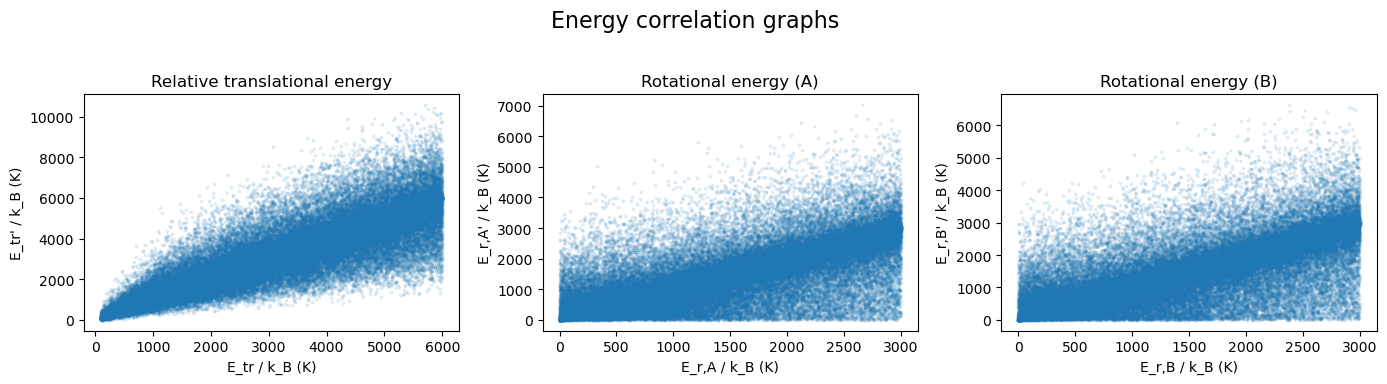

In [8]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.scatter(df['Etr'], df['Etrp'], s=3, alpha=0.1)
plt.xlabel("E_tr / k_B (K)"); plt.ylabel("E_tr' / k_B (K)")
plt.title("Relative translational energy")

plt.subplot(1,3,2)
plt.scatter(df['Er1'], df['Er1p'], s=3, alpha=0.1)
plt.xlabel("E_r,A / k_B (K)"); plt.ylabel("E_r,A' / k_B (K)")
plt.title("Rotational energy (A)")

plt.subplot(1,3,3)
plt.scatter(df['Er2'], df['Er2p'], s=3, alpha=0.1)
plt.xlabel("E_r,B / k_B (K)"); plt.ylabel("E_r,B' / k_B (K)")
plt.title("Rotational energy (B)")

plt.suptitle("Energy correlation graphs", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

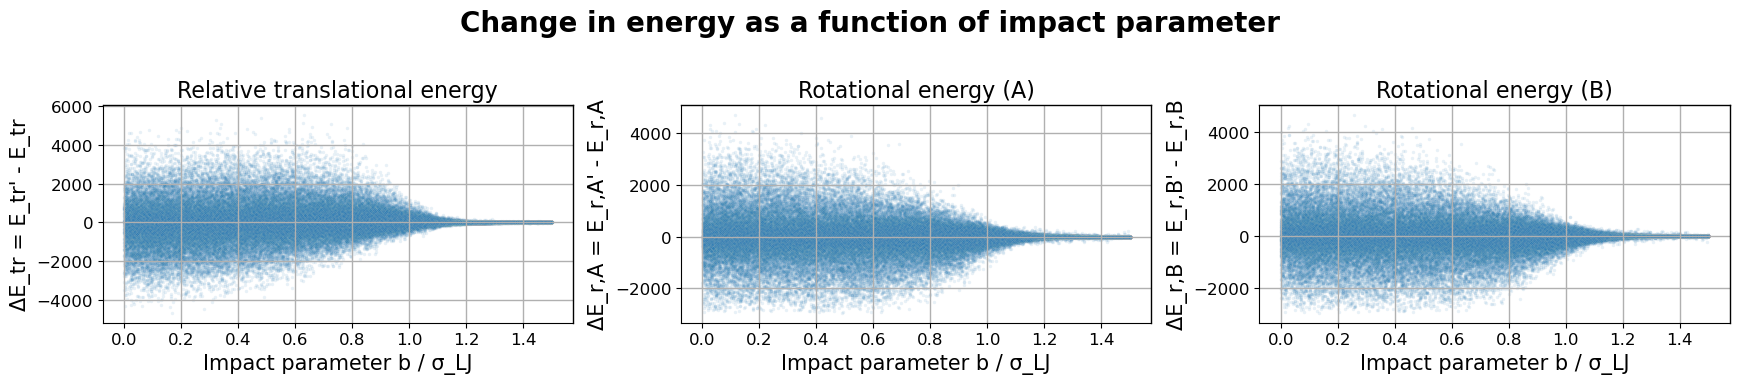

In [3]:
import seaborn as sns

# Compute energy differences
dEtr = df['Etrp'] - df['Etr']
dEr1 = df['Er1p'] - df['Er1']
dEr2 = df['Er2p'] - df['Er2']
b = df['b']

# Create figure and tiled layout
fig, axes = plt.subplots(1, 3, figsize=(14*2.5/2, 4*1.0))  # mimic MATLAB size

# 1. Relative translational energy
sns.scatterplot(x=b, y=dEtr, ax=axes[0], s=6, alpha=0.1)
axes[0].set_xlabel("Impact parameter b / σ_LJ", fontsize=15)
axes[0].set_ylabel("ΔE_tr = E_tr' - E_tr", fontsize=15)
axes[0].set_title("Relative translational energy", fontsize=16)
axes[0].tick_params(labelsize=12)
axes[0].grid(True, linewidth=1)
axes[0].spines['top'].set_linewidth(1)
axes[0].spines['right'].set_linewidth(1)

# 2. Rotational energy (A)
sns.scatterplot(x=b, y=dEr1, ax=axes[1], s=6, alpha=0.1)
axes[1].set_xlabel("Impact parameter b / σ_LJ", fontsize=15)
axes[1].set_ylabel("ΔE_r,A = E_r,A' - E_r,A", fontsize=15)
axes[1].set_title("Rotational energy (A)", fontsize=16)
axes[1].tick_params(labelsize=12)
axes[1].grid(True, linewidth=1)
axes[1].spines['top'].set_linewidth(1)
axes[1].spines['right'].set_linewidth(1)

# 3. Rotational energy (B)
sns.scatterplot(x=b, y=dEr2, ax=axes[2], s=6, alpha=0.1)
axes[2].set_xlabel("Impact parameter b / σ_LJ", fontsize=15)
axes[2].set_ylabel("ΔE_r,B = E_r,B' - E_r,B", fontsize=15)
axes[2].set_title("Rotational energy (B)", fontsize=16)
axes[2].tick_params(labelsize=12)
axes[2].grid(True, linewidth=1)
axes[2].spines['top'].set_linewidth(1)
axes[2].spines['right'].set_linewidth(1)

# Super title
fig.suptitle("Change in energy as a function of impact parameter", fontsize=20, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [4]:
from scipy.stats import gaussian_kde

def dscatter(x,y):
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    plt.scatter(x,y,c=z, s=3)

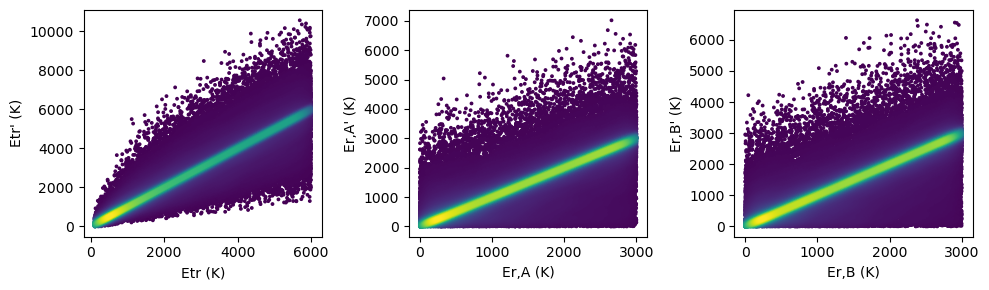

In [5]:
plt.figure(figsize=[10,3])

plt.subplot(1,3,1)
plt.xlabel("Etr (K)")
plt.ylabel("Etr' (K)")
dscatter(df['Etr'],df['Etrp'])


plt.subplot(1,3,2)
plt.xlabel("Er,A (K)")
plt.ylabel("Er,A' (K)")
dscatter(df['Er1'],df['Er1p'])


plt.subplot(1,3,3)
plt.xlabel("Er,B (K)")
plt.ylabel("Er,B' (K)")
dscatter(df['Er2'],df['Er2p'])
plt.tight_layout()
plt.show()

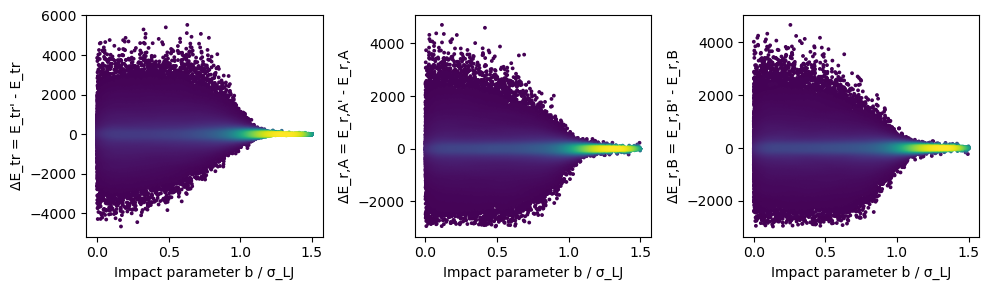

In [6]:
plt.figure(figsize=[10,3])

plt.subplot(1,3,1)
plt.xlabel("Impact parameter b / σ_LJ")
plt.ylabel("ΔE_tr = E_tr' - E_tr")
dscatter(df['b'],df['Etrp'] - df['Etr'])


plt.subplot(1,3,2)
plt.xlabel("Impact parameter b / σ_LJ")
plt.ylabel("ΔE_r,A = E_r,A' - E_r,A")
dscatter(df['b'],df['Er1p']-df['Er1'])


plt.subplot(1,3,3)
plt.xlabel("Impact parameter b / σ_LJ")
plt.ylabel("ΔE_r,B = E_r,B' - E_r,B")
dscatter(df['b'],df['Er2p']-df['Er2'])
plt.tight_layout()
plt.show()